This notebook will be used to model/schematize the construction of V1 receptive fields from LGN inputs. In particular, we want to analyze how the spatial arrangement of inputs and the tuning of the LGN neurons themselves influence V1 selectivity, and ask if the LGN arrangement/tuning matters for all - or only some - V1 neurons.

Created:   20.01.14  
Updated:   20.01.14  
Accessed:  20.01.14  

In [7]:
import numpy as np
import helper_fcns as hf
import itertools
import warnings
warnings.filterwarnings('once')

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import seaborn as sns

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

%matplotlib inline 

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 42 # should be 42; 3 works if there are kerning issues
rcParams['ps.fonttype'] = 42 # should be 42; 3 works if there are kerning issues

# Haphazard wiring

Let's try and recreate Ringach 2004. Here, he defines a hexagonal latice: 

$\vec{\mathbf{x}}$ = $\lambda$ * $\begin{pmatrix} 1 & 1 \\\ \sqrt{3} & -\sqrt{3} \end{pmatrix}$ * $\begin{pmatrix} i \\\ j \end{pmatrix}$ + $\vec{n}$

### First, the retinal mosaic

In [105]:
# sc_factor = 1;
sc_factor = 1/2.0; # Note the additional factor of 0.5 -- this comes from Paik and Ringach (2011) and 
# brings us closer to the reported values in the 2004 paper

loc_x = lambda lm, i, j, sig_pos: lm*sc_factor*(i+j) + np.random.normal(loc=0, scale=lm*sig_pos, size=1)
loc_y = lambda lm, i, j, sig_pos: lm*sc_factor*np.sqrt(3)*(i-j) + np.random.normal(loc=0, scale=lm*sig_pos, size=1)

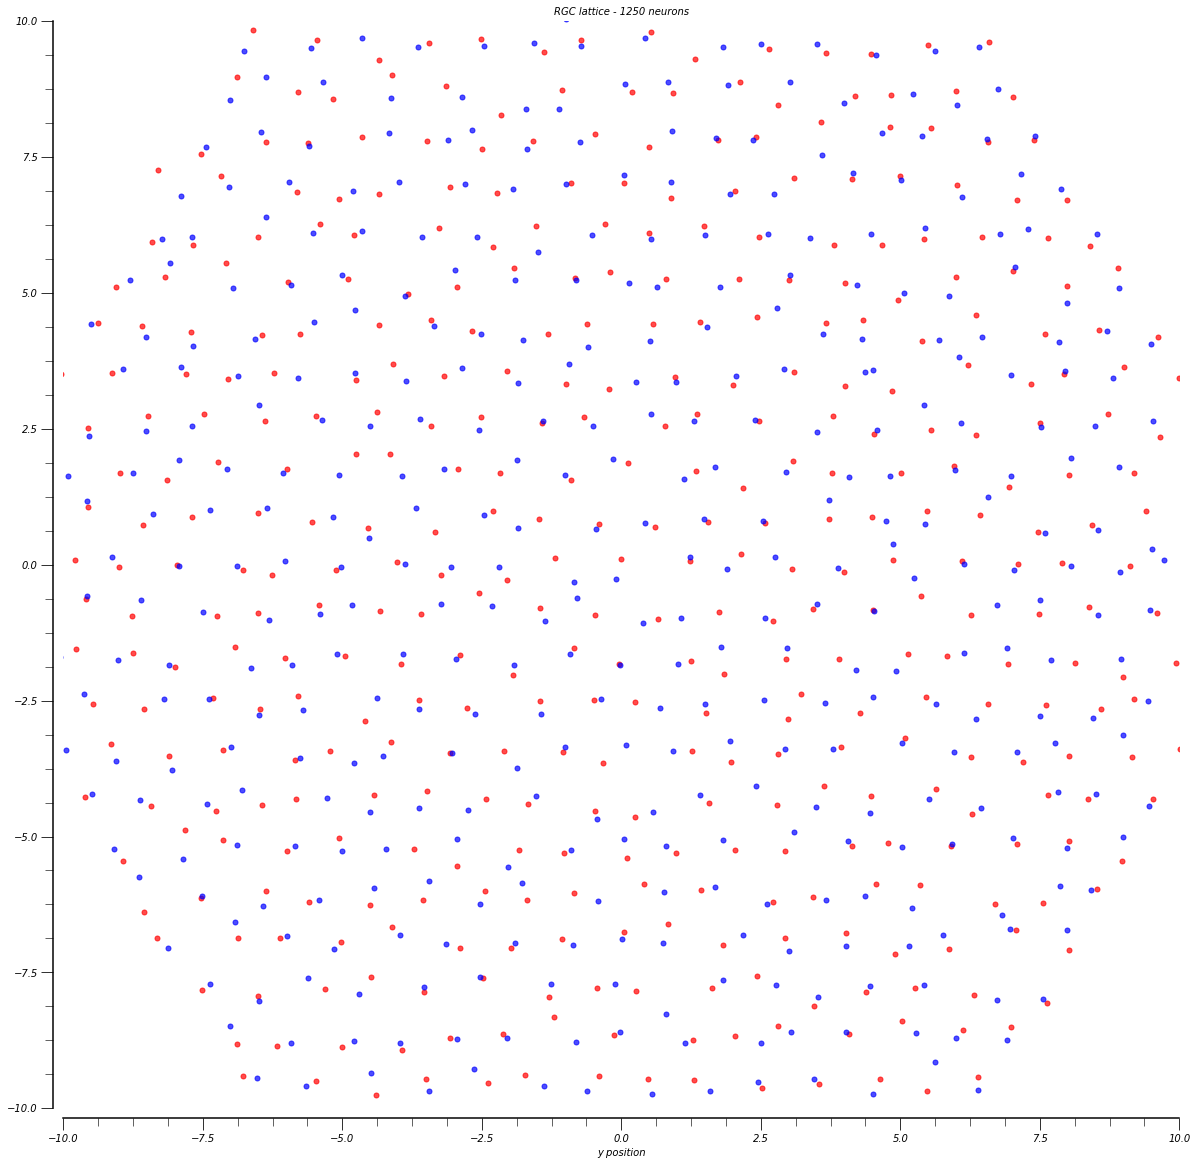

In [113]:
to_plt = 1;
steps = 12;

exclude_edge = 0;

lm = 1;
# lm = 1/np.sqrt(2.0);
# sig_ringach = 0;
sig_ringach = 0.155;
# sig_ringach = 0.03;

on_locs = [];
off_locs = [];

if to_plt:
    f = plt.figure(figsize=(20, 20))

for i,j in itertools.product(np.arange(-steps, steps+1), np.arange(-steps, steps+1)):


    ## first "on"
    x, y = loc_x(lm, i, j, sig_ringach)[0], loc_y(lm, i, j, sig_ringach)[0];
    if ~exclude_edge or (i > -steps and i < steps and j > -steps and j < steps):
        on_locs.append(np.array([x, y]))
    if to_plt:
        plt.scatter(x, y, c='r', alpha=0.7, label='on')
    ## then "off"
    x, y = loc_x(lm, i, j, sig_ringach)[0], loc_y(lm, i, j, sig_ringach)[0];
    if ~exclude_edge or (i > -steps and i < steps and j > -steps and j < steps):
        off_locs.append(np.array([x, y]))
    if to_plt:
        plt.scatter(x, y, c='b', alpha=0.7, label='off')

if to_plt:
    sns.despine(offset=10)
    plt.axis('equal');
    plt.axis('tight');
    plt.xlabel('x position')
    plt.xlabel('y position')
    plt.title('RGC lattice - %d neurons' % (2*np.square(2*steps+1)))
    # now, trim the figure so that we make it a square
    plt.xlim([-np.minimum(10, steps)*lm, np.minimum(10, steps)*lm]);
    plt.ylim([-np.minimum(10, steps)*lm, np.minimum(10, steps)*lm]);
    

In [114]:
### Now, compute the distribution of distances between locations - first within class then, across
# within class:
on_min = [];
off_min = [];
for i,j in zip(on_locs, off_locs):
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    on_min.append(np.partition(np.sqrt(np.sum(np.square(i - on_locs), 1)), 1)[1])
    off_min.append(np.partition(np.sqrt(np.sum(np.square(j - off_locs), 1)), 1)[1])

for dta, lbl in zip((on_min, off_min), ('on', 'off')):
    mn, sd = np.mean(dta), np.std(dta);
    print('%s: mn %.2f +- %.2f --- CV %.3f' % (lbl, mn, sd, np.divide(sd, mn)))
    
# independent of class:
all_locs = np.vstack((on_locs, off_locs));
both_min = [];
for i in all_locs:
    # this computes the distance, then gets the 2nd smallest (1st smallest is self-distance, i.e. 0!)
    both_min.append(np.partition(np.sqrt(np.sum(np.square(i - all_locs), 1)), 1)[1])
    
mn_both, sd_both = np.mean(both_min), np.std(both_min);
print('%s: mn %.2f +- %.2f --- CV %.3f' % ('all locations', mn_both, sd_both, np.divide(sd_both, mn_both)))

on: mn 0.76 +- 0.13 --- CV 0.168
off: mn 0.74 +- 0.13 --- CV 0.176
all locations: mn 0.26 +- 0.13 --- CV 0.494


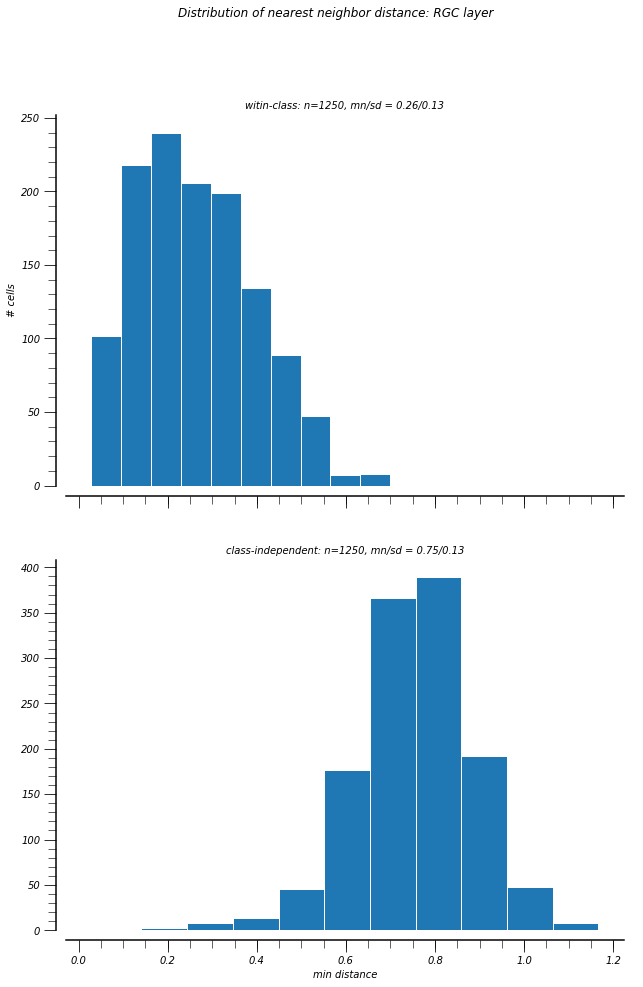

In [115]:
all_dist_within = np.hstack((on_min, off_min));

f, ax = plt.subplots(2, 1, figsize=(10, 15), sharex=True)
f.suptitle('Distribution of nearest neighbor distance: RGC layer')

sns.despine(offset=10)

ax[0].hist(both_min);
ax[0].set_title('witin-class: n=%d, mn/sd = %.2f/%.2f' % (len(both_min), mn_both, sd_both));
ax[0].set_ylabel('# cells');

ax[1].hist(all_dist_within);
ax[1].set_title('class-independent: n=%d, mn/sd = %.2f/%.2f' % (len(all_dist_within), np.mean(all_dist_within), np.std(all_dist_within)));
ax[1].set_xlabel('min distance');


### Then, create the LGN layer

_"The layer of LGN neurons was constructed by replicating the original RGC layer and adding 1.5 times more receptive fields. This was done by random sampling (with replacement) to result in a total of 2.5 times the number of original RGCs. This assumes that each LGN neuron receives dominant input from only one retinal afferent (Cleland and Lee 1985; Cleland et al. 1971)"_ - Ringach, 2004

In [116]:
# so, let's sample from "all_locs", which combines the locations of on- and off-center RGC. 
# but, we'll keep track of on and off identity

all_locs = np.vstack((on_locs, off_locs));
all_ids = np.hstack((np.ones((len(on_locs), )), np.zeros((len(off_locs), ))));

n_RGC = len(all_locs);
n_to_draw = np.int(1.5*n_RGC)

inds = np.random.randint(low=0, high=n_RGC, size=n_to_draw)
new_locs = all_locs[inds];
new_ids = all_ids[inds];

LGN_locs = np.vstack((all_locs, new_locs))
LGN_ids = np.hstack((all_ids, new_ids))

on_inds = np.where(LGN_ids == 1)[0];
off_inds = np.where(LGN_ids == 0)[0];

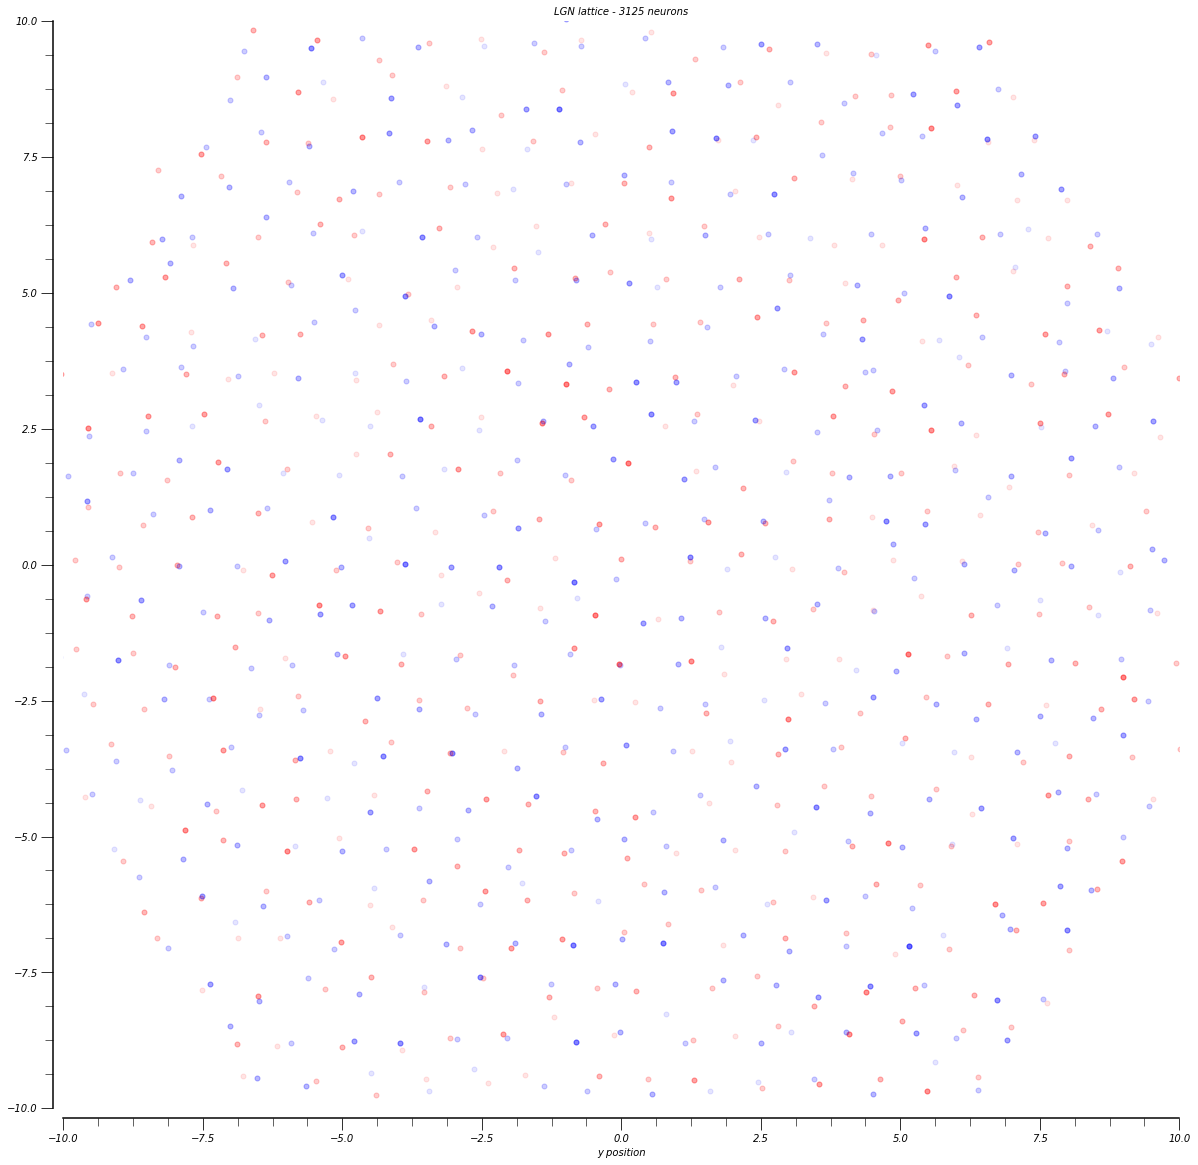

In [117]:
# now, let's plot
# -- by reducing the "alpha" of each point, it's visible which points have been resampled
#      simply because the multiple overlaid points will appear darker!

to_plt = 1;

if to_plt:
    f = plt.figure(figsize=(20, 20))

for i, loc in enumerate(LGN_locs):

    # on or off?
    is_on = LGN_ids[i];
    if is_on == 1:
        c = 'r';
    else:
        c= 'b'
    
    ## first "on"
    if to_plt:
        plt.scatter(loc[0], loc[1], c=c, alpha=0.1, label='on')

if to_plt:
    sns.despine(offset=10)
    plt.axis('equal');
    plt.axis('tight');
    plt.xlabel('x position')
    plt.xlabel('y position')
    plt.title('LGN lattice - %d neurons' % len(LGN_locs))
    # now, trim the figure so that we make it a square
    plt.xlim([-np.minimum(10, steps)*lm, np.minimum(10, steps)*lm]);
    plt.ylim([-np.minimum(10, steps)*lm, np.minimum(10, steps)*lm]);